<a href="https://colab.research.google.com/github/edivet92/NLP/blob/edivet92-patch-5/Egorov_Denis_NLP_HW_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Практическое задание 11
Разобраться с моделькой перевода как она устроена (c механизмом внимания), запустить для перевода с русского на английский (при желании можно взять другие пары языков)
**внимание классическое** с RNN-ками в энкодере и декодере
ноутбук в архиве
lesson11_actual.zip
называется
`nmt_with_attention.ipynb`

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

### Скачаем данные

In [2]:
!wget http://www.manythings.org/anki/rus-eng.zip

--2023-09-12 13:07:35--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15824155 (15M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  15.09M  55.0MB/s    in 0.3s    

2023-09-12 13:07:36 (55.0 MB/s) - ‘rus-eng.zip’ saved [15824155/15824155]



In [3]:
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [4]:
!ls /content/rus-eng/ -lah

total 76M
drwxr-xr-x 2 root root 4.0K Sep 12 13:07 .
drwxr-xr-x 1 root root 4.0K Sep 12 13:07 ..
-rw-r--r-- 1 root root 1.5K Jul 30 03:53 _about.txt
-rw-r--r-- 1 root root  76M Jul 30 03:53 rus.txt


In [5]:
# Download the file
path_to_file = "/content/rus-eng/rus.txt"

In [6]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [7]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [8]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, RUS]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [17]:
en, ru = create_dataset(path_to_file, None)
print(en[-1])
print(ru[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на земле людей , ни один подходящи

In [18]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [19]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Обрежем датасет чтобы потратить меньше времени

In [20]:
len(en), len(ru)

(479223, 479223)

In [21]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [22]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [23]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [24]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
10 ----> ты
210 ----> разве
7 ----> не
840 ----> адвокат
5 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
169 ----> aren't
7 ----> you
9 ----> a
729 ----> lawyer
6 ----> ?
2 ----> <end>


### Создадим tf.data датасет

In [25]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [26]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

#### GRU в энкодере, в отличие от NMT без внимания должен возващать последовательности

In [27]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [28]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print (f'Encoder output shape: (batch size, sequence length, units) {sample_output.shape}')
print (f'Encoder Hidden state shape: (batch size, units) {sample_hidden.shape}')

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


#### Блок внимания

In [29]:
class BahdanauAttention(tf.keras.layers.Layer): #Богданов атэншн
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [30]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print(f"Attention result shape: (batch size, units) {attention_result.shape}")
print(f"Attention weights shape: (batch_size, sequence_length, 1) {attention_weights.shape}")

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


#### Декодер

In [31]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [32]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print (f'Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab size) (64, 7386)


### Определим оптимизатор и функцию потерь

In [33]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Будем сохранять веса в процессе обучения

In [34]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### tf фунцкия обучения

In [35]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

### Обучение

In [36]:
EPOCHS = 25

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7955
Epoch 1 Batch 100 Loss 2.1738
Epoch 1 Batch 200 Loss 1.8519
Epoch 1 Batch 300 Loss 1.6767
Epoch 1 Batch 400 Loss 1.5961
Epoch 1 Batch 500 Loss 1.5449
Epoch 1 Batch 600 Loss 1.4978
Epoch 1 Batch 700 Loss 1.3839
Epoch 1 Batch 800 Loss 1.3436
Epoch 1 Batch 900 Loss 1.2320
Epoch 1 Batch 1000 Loss 1.1368
Epoch 1 Batch 1100 Loss 1.1036
Epoch 1 Batch 1200 Loss 0.9709
Epoch 1 Loss 1.4781
Time taken for 1 epoch 126.98161673545837 sec

Epoch 2 Batch 0 Loss 0.7783
Epoch 2 Batch 100 Loss 0.8067
Epoch 2 Batch 200 Loss 0.7634
Epoch 2 Batch 300 Loss 0.7248
Epoch 2 Batch 400 Loss 0.7097
Epoch 2 Batch 500 Loss 0.6664
Epoch 2 Batch 600 Loss 0.6546
Epoch 2 Batch 700 Loss 0.6054
Epoch 2 Batch 800 Loss 0.5292
Epoch 2 Batch 900 Loss 0.6177
Epoch 2 Batch 1000 Loss 0.5681
Epoch 2 Batch 1100 Loss 0.5662
Epoch 2 Batch 1200 Loss 0.6160
Epoch 2 Loss 0.6652
Time taken for 1 epoch 98.26446866989136 sec

Epoch 3 Batch 0 Loss 0.3096
Epoch 3 Batch 100 Loss 0.3299
Epoch 3 Batch 200 Loss 0.35

### Перевод

In [37]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [43]:
# функция для отрисовки весов внимания
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [39]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [41]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> здесь хорошо . <end>
Predicted translation: it's fine here . <end> 


<ipython-input-43-110c8b964a70>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-43-110c8b964a70>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


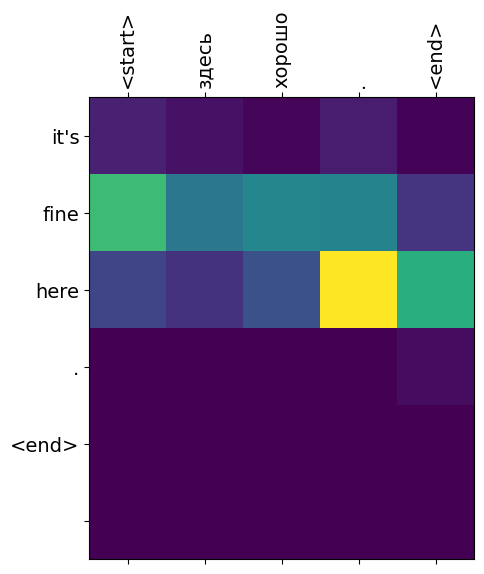

In [45]:
translate('Здесь хорошо.')

Input: <start> сегодня хорошая погода <end>
Predicted translation: it's fine today . <end> 


<ipython-input-43-110c8b964a70>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-43-110c8b964a70>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


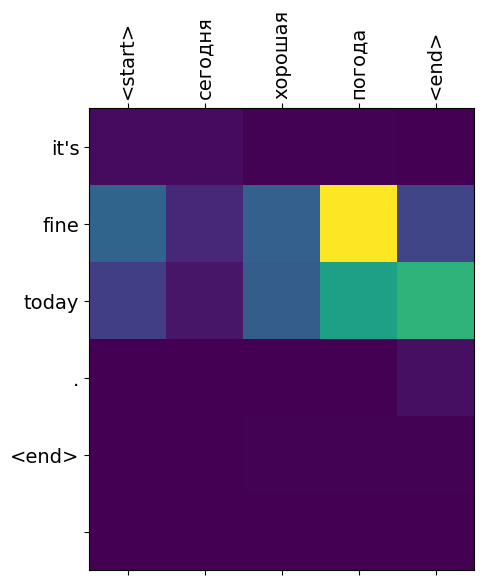

In [44]:
translate('Сегодня хорошая погода')

Input: <start> я заболел , сегодня не поеду на работу . <end>
Predicted translation: i stay up to work . <end> 


<ipython-input-43-110c8b964a70>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-43-110c8b964a70>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


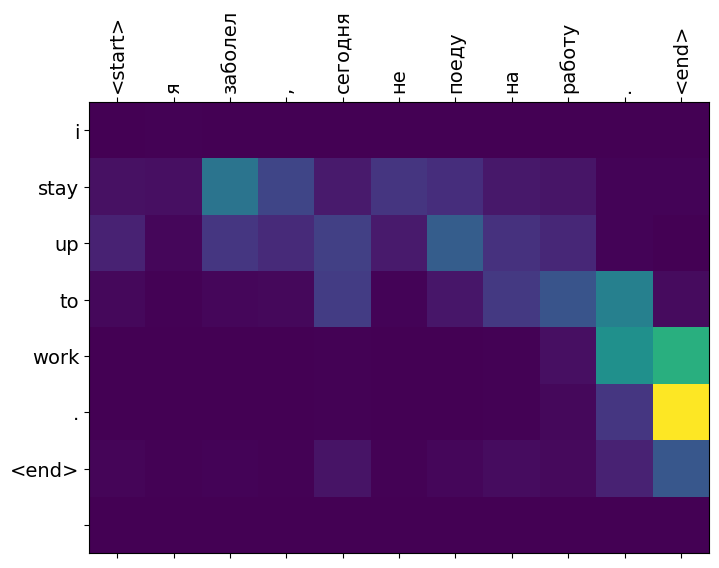

In [49]:
translate(u'Я заболел, сегодня не поеду на работу.')

In [50]:
text_to_translate = 'Жили-были старик со старухой. Вот и говорит старик старухе: — Поди-ка, старуха, по коробу поскреби, по сусеку помети, не наскребешь ли муки на колобок.'

In [51]:
translate(text_to_translate)

KeyError: ignored

In [64]:
text_to_translate = 'Привет, как дела? Я сегодня заболел, на работу не поеду. Останусь дома, буду валяться и пить пиво как неудачник'

Input: <start> привет , как дела ? я сегодня заболел , на работу не поеду . останусь дома , буду валяться и пить пиво как неудачник <end>
Predicted translation: don't be not go out to work . <end> 


<ipython-input-43-110c8b964a70>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-43-110c8b964a70>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


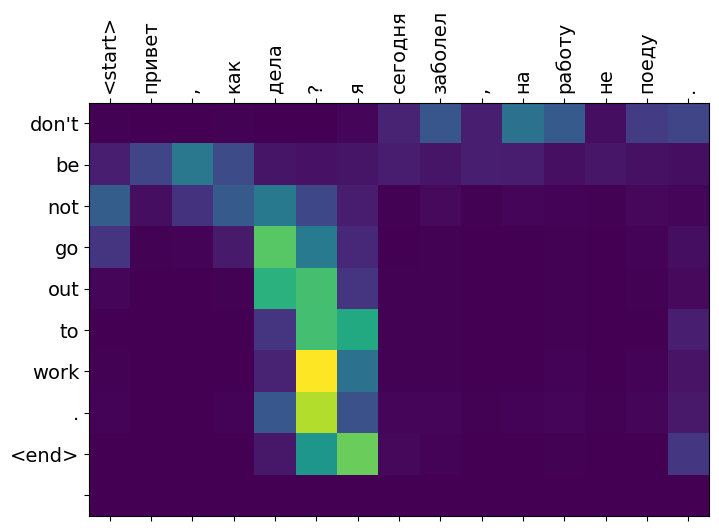

In [65]:
translate(text_to_translate)

Нейронный машинный перевод (NMT) с вниманием в TensorFlow (TF) в последние годы приобрел значительное внимание и популярность благодаря своей способности улучшать качество перевода по сравнению с традиционными подходами к машинному переводу. Однако, как и любая технология, она имеет свои преимущества и недостатки.

Преимущества НМТ с вниманием в TF:

1. Улучшенное качество перевода. Одним из основных преимуществ NMT с вниманием является его способность производить переводы более высокого качества. Модели NMT продемонстрировали значительный прогресс в улавливании сложных языковых паттернов и обеспечении более беглых и точных переводов. Механизм внимания позволяет модели сосредоточиться на соответствующих частях исходного предложения при создании целевого перевода, что приводит к повышению связности и точности.

2. Сквозное обучение: модели NMT с вниманием обеспечивают сквозное обучение, что означает, что весь процесс перевода изучается связанно от исходного ввода (исходное предложение) до вывода (целевой перевод). Это устраняет необходимость в ручном проектировании признаков или промежуточных представлениях, что делает процесс обучения более рациональным и эффективным. Сквозное обучение также позволяет модели эффективно фиксировать долгосрочные зависимости и контекстную информацию.

3. Гибкость и адаптируемость: модели NMT с вниманием очень гибки и адаптируются к различным языковым парам и областям. В отличие от систем SMT (статистический машинный перевод), основанных на правилах или фразах, которые требуют обширной ручной настройки для каждой языковой пары, модели NMT можно обучать на параллельных корпусах различных языков без существенных модификаций. Такая гибкость упрощает масштабирование систем NMT для нескольких языковых пар или адаптацию их к конкретным областям или задачам.

4. Контекстно-зависимые переводы. Механизм внимания в моделях NMT позволяет им учитывать все исходное предложение при создании каждого слова целевого перевода. Понимание контекста помогает разрешать двусмысленности и производить более точные переводы, принимая во внимание соответствующую информацию из исходного предложения. Это позволяет модели улавливать зависимости между удаленными словами и более эффективно обрабатывать сложные синтаксические структуры.

5. Снижение зависимости от функций, созданных вручную. В отличие от традиционных систем SMT, которые в значительной степени полагаются на созданные вручную лингвистические функции, модели NMT с вниманием изучают функции автоматически на основе данных. Это уменьшает необходимость в ручном проектировании функций и делает процесс перевода более управляемым данными. Изучая представления непосредственно из входных данных, модели NMT могут улавливать тонкие лингвистические нюансы и улучшать качество перевода.

Недостатки НМТ с вниманием в ТФ:

1. Вычислительная сложность: модели NMT с вниманием, как правило, являются более дорогими в вычислительном отношении по сравнению с традиционными системами SMT. Механизм внимания требует дополнительных вычислений для согласования исходных и целевых слов, что может значительно увеличить время обучения и вывода. Внимательное обучение крупномасштабных моделей NMT может потребовать мощных аппаратных ресурсов, таких как графические или тензорные процессоры, для достижения разумного времени обучения.

2. Требования к данным. Модели NMT с вниманием обычно требуют большого количества параллельных корпусов для обучения для достижения оптимальной производительности. Получение высококачественных параллельных данных может быть сложной задачей, особенно для языков с ограниченными ресурсами или специализированных областей, где доступны ограниченные параллельные корпуса. Недостаток обучающих данных может привести к плохому обобщению и снижению качества перевода.

3. Отсутствие интерпретируемости. Хотя модели NMT с вниманием показали впечатляющую эффективность перевода, им часто не хватает интерпретируемости по сравнению с традиционными системами SMT. Природа глубоких нейронных сетей (как черный ящик) затрудняет понимание того, как модель достигает своих переводов, или выявление конкретных ошибок в выходных данных. Отсутствие интерпретируемости может быть недостатком в некоторых приложениях, где прозрачность и объяснимость имеют решающее значение.

В заключение, NMT с вниманием в TensorFlow предлагает несколько преимуществ, таких как улучшенное качество перевода, сквозное обучение, гибкость, адаптируемость, контекстно-зависимые переводы и меньшая зависимость от функций, созданных вручную. Однако он также имеет некоторые недостатки, включая вычислительную сложность, требования к данным и отсутствие интерпретируемости. Несмотря на эти ограничения, NMT произвел революцию в области машинного перевода и продолжает оставаться активной областью исследований и разработок.



1. "Neural Machine Translation by Jointly Learning to Align and Translate" by Dzmitry Bahdanau et al.
2. "Attention Is All You Need" by Vaswani et al.
3. https://www.tensorflow.org

В заключение ссылка на небольшое интервью с Дмитрием Богдановым

https://dzen.ru/a/XKSFq3IBtQCy-_By